In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("imported")
import random
import os
import sys
import itertools
sys.path.append('src/')
import nibabel as nib
from math import floor, ceil
from __future__ import division, print_function, absolute_import
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure
from skimage.io import imread, imsave
import numpy
from PIL import Image
from scipy.ndimage import rotate


imported


# Helper functions 

In [2]:
#How to use: Change directory of nifti files (In[7]) and then change what name you want the file to be (In[78])

In [3]:
def split_filename(filename):
    """
    Splits filename for a trial into 'trial10_30_w1', True if seg[label], False if vol[raw]
    """
    fn_lst = filename.split('_')
    if len(fn_lst) >= 4:
        trial_name = "_".join(fn_lst[:3])
        if 'seg' in fn_lst[3]:  
            return trial_name, True
        elif 'vol' in fn_lst[3]:
            return trial_name, False
    else:
        return None, None


def bounding_box(img):
    """
    Returns copy of the img bounded by the box from the image.
    """

    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    box = img[rmin : rmax, cmin : cmax]
    img = box

In [4]:
def build_image_dataset(trial_key, raw_nii, label_nii, base_data_dir, base_img_data_dir):
    raw_nii_file = os.path.join(base_data_dir, raw_nii)
    label_nii_file = os.path.join(base_data_dir, label_nii)
    raw_voxel = nib.load(raw_nii_file).get_data()
    label_voxel = nib.load(label_nii_file).get_data()
    
    counter = 0
    trial_img_dir = os.path.join(base_img_data_dir, trial_key)
    if not os.path.exists(trial_img_dir):
        os.makedirs(trial_img_dir)
    raw_clean_voxel, labeled_clean_voxel = None, None
    for i in range(raw_voxel.shape[0]):  # shape is (1188, 482, 395)
        if empty_img(raw_voxel[i]) or empty_img(label_voxel[i]):
            continue
            
        raw_img = raw_voxel[i]
        labeled_img = fill(label_voxel[i])  # Grid fill the labeled image
        
        scipy.misc.imsave(os.path.join(trial_img_dir, str(counter) + '_raw.png'), raw_img)
        scipy.misc.imsave(os.path.join(trial_img_dir, str(counter) + '_label.png'), labeled_img)
        
        counter += 1

# Slicing




In [5]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray",origin="lower")

# Coordinate Segmentation

In [6]:
img = nib.load('/Users/saimandava/Desktop/allrawfillednifti/trial_22/trial22_90_w3_proc_filled_seg.nii')
# img = nib.load('/Users/saimandava/Desktop/60deg_nifti/trial15_60_w1_volume_TRANS.nii')
# imgnew = nib.load('/Users/saimandava/Desktop/30deg_nifti/trial8_30_fs_seg_ak5_lh4_TRANS.nii')
#change directory of file you want to segment; everything else is set

In [7]:
img_data = img.get_data()

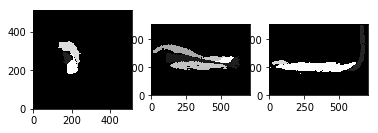

In [8]:
xpart = img_data[182, :, :]
ypart = img_data[:, 178, :]
zpart = img_data[:, :, 198]
# new_x_part = img_data[]

show_slices([xpart,ypart,zpart])

# Save image



In [9]:
data = img.get_data()

In [10]:
img1 = nib.Nifti1Image(xpart.reshape((-1,512, 512)),img.affine,img.header)
# img2 = nib.Nifti1Image(ypart.reshape((707,-1,512)), img.affine, img.header) 
# img3 = nib.Nifti1Image(zpart.reshape((707,512,-1)), img.affine, img.header)

In [11]:
count = '5'
i = 1
count+=('1')
count+=('1')
nib.save(img1, '0_' + count + '.nii')

# nib.save(img2, 'side_coord_001.nii')
# nib.save(img3, 'full_coord_001.nii')
#change names depending on type of file

# Rotational segmentation

In [12]:
from nibabel.affines import apply_affine

In [13]:
cos_gamma = np.cos(0.3)
sin_gamma = np.sin(0.3)
rotation_affine = np.array([[1, 0, 0, 0],[0, cos_gamma, -sin_gamma, 0],[0, sin_gamma, cos_gamma, 0],[0, 0, 0, 1]])

In [14]:
scaling_affine = np.array([[126, 0, 0, 0],[0, 126, 0, 0],[0, 0, 126, 0],[0, 0, 0, 126]])
affine_so_far = rotation_affine.dot(scaling_affine)

In [15]:
translation_affine = np.array([[1, 0, 0, 15],[0, 1, 0, 12],[0, 0, 1, 5],[0, 0, 0, 1]])

In [16]:
whole_affine = translation_affine.dot(affine_so_far)

# Save image

In [17]:
img_affine1 = nib.Nifti1Image(xpart.reshape((-1,512, 512)), whole_affine, img.header)
# img_affine2 = nib.Nifti1Image(ypart.reshape((707,-1,512)), whole_affine, img.header)
# img_affine3 = nib.Nifti1Image(zpart.reshape((707,512,-1)), whole_affine, img.header)

In [18]:
# nib.save(img_affine1, '2d_rotate_90_001.nii')
# nib.save(img_affine2, 'test_transform_002.nii')
# nib.save(img_affine3, 'test_transform_003.nii') #uncomment for later use

# 3D Image Rotation

In [19]:
img3d = nib.load('/Users/saimandava/Desktop/allrawfillednifti/trial_22/trial22_90_w3_proc_filled_seg.nii')

In [20]:
data3d = img3d.get_data()

In [21]:
image_rotate=rotate(data3d, angle=60, reshape=False, axes=(1,2), order=1) #can change angle and axes for different data

In [22]:
img3d1 = nib.Nifti1Image(image_rotate,img.affine,img.header)

In [23]:
# nib.save(img3d1, '3d_rotate_90_001.nii')

# Slicing of 3D Rotation

In [24]:
img_new = nib.load('/Users/saimandava/Desktop/3d_rotate_90_001.nii')

FileNotFoundError: No such file: '/Users/saimandava/Desktop/3d_rotate_90_001.nii'

In [ ]:
type(img_new)

In [ ]:
imgnewD = img_new.get_data()

In [ ]:
xpartD = imgnewD[182, :, :]
ypartD = imgnewD[:, 178, :]
zpartD = imgnewD[:, :, 198]
# new_x_part = img_data[]

show_slices([xpartD,ypartD,zpartD])

# Save image

In [ ]:
img13d = nib.Nifti1Image(xpartD.reshape((-1,512, 512)),img.affine,img.header)
# img23d = nib.Nifti1Image(ypartD.reshape((707,-1,512)), img.affine, img.header) 
# img33d = nib.Nifti1Image(zpartD.reshape((707,512,-1)), img.affine, img.header)

In [ ]:
# nib.save(img13d, '3d_slice_90_001.nii')
# nib.save(img2, '3d_slice_90_002.nii')
# nib.save(img3, '3d_slice_90_003.nii')
#change names depending on type of file

# Conversion

In [3]:
#arr = [15,30,45,60,90]
arr = [45,135,225,315]
counter = '30'
for filename in os.listdir('/Users/saimandava/Desktop/allrawfillednifti/trial_12'):
    img3d = nib.load('/Users/saimandava/Desktop/allrawfillednifti/trial_12/' + filename)
    data3d = img3d.get_data()
    xpart = img_data[182, :, :]
    ypart = img_data[:, 178, :]
    zpart = img_data[:, :, 198]
    for a in arr:
        image_rotate=rotate(data3d, angle=a, reshape=False, axes=(1,0), order = 0) #can change angle and axes for different data
        img3d1 = nib.Nifti1Image(image_rotate,img.affine,img.header)
        nib.save(img3d1, 'trial12_30_w3_rot' + counter + '.nii')
        counter +=('1')

NameError: name 'img' is not defined